In [ ]:
!pip install adversarial-robustness-toolbox

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 1.4 MB 17.6 MB/s 


In [ ]:
# Imports
import keras
import random
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf

from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K

from art.attacks.evasion import CarliniL2Method, SaliencyMapMethod, ElasticNet
from art.estimators.classification import KerasClassifier
from sklearn.metrics import zero_one_loss, accuracy_score


# Set the random seeds. Do not change this!
seedVal = 41
random.seed(seedVal)
np.random.seed(seedVal)

# Define some constants.
NUM_CLASSES = 10
BATCH_SIZE = 32

In [ ]:
tf.compat.v1.disable_eager_execution()

## Part 1

### You need to complete the following.

In [ ]:
# Load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES)

K.set_image_data_format('channels_first')
print(x_train.shape)
# Reshape the data.
x_train = x_train.reshape(60000,1, 28, 28)
print(x_train.shape)
x_test = x_test.reshape(10000,1, 28, 28)

11490434/11490434 [==============================] - 2s 0us/step
(60000, 28, 28)
(60000, 1, 28, 28)


In [ ]:
# Build a training dataset for the substitute model
# Collect ten images from each dataset class (numbers 0-9)
selected_examples = []
for target_label in range(0, 10):
    count = 0
    for i in range(y_train.shape[0]):
        if y_train[i].tolist().index(1) == target_label:
            count += 1
            selected_examples.append((x_train[i, :, :], y_train[i]))
            if count == 10:
                break

#print(selected_examples)
# Convert selected examples to numpy array
final_train_x =  np.array([x[0] for x in selected_examples])
final_train_y = np.array([x[1] for x in selected_examples])

In [ ]:
# Train a CNN-based substitute model using the newly collected dataset
substitute_model = Sequential()

# Define the intermediate layers.
substitute_model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=(1,28,28)))

#64 convolution filters used each of size 3x3
substitute_model.add(Conv2D(64, (3, 3), activation='relu'))

#choose the best features via pooling
substitute_model.add(MaxPooling2D(pool_size=(2, 2)))

#flatten
substitute_model.add(Flatten())

# #fully connected
substitute_model.add(Dense(128, activation='relu'))
substitute_model.add(Dropout(0.5))

substitute_model.add(Dense(NUM_CLASSES, activation='softmax'))

# Compile the model
substitute_model.compile(optimizer='adam', 
              loss='sparse_categorical_crossentropy', 
              metrics=['accuracy'])

substitute_model = KerasClassifier(model=substitute_model, clip_values=(0,1))

# Fit the model
substitute_model.fit(final_train_x, final_train_y, nb_epochs=10, batch_size=BATCH_SIZE)

Train on 100 samples
Epoch 1/10
100/100 [==============================] - 9s 90ms/sample - loss: 2.2791 - accuracy: 0.1700
Epoch 2/10
100/100 [==============================] - 0s 443us/sample - loss: 1.9513 - accuracy: 0.5200
Epoch 3/10
100/100 [==============================] - 0s 398us/sample - loss: 1.6517 - accuracy: 0.5600
Epoch 4/10
100/100 [==============================] - 0s 293us/sample - loss: 1.2081 - accuracy: 0.6300
Epoch 5/10
100/100 [==============================] - 0s 351us/sample - loss: 1.0970 - accuracy: 0.6500
Epoch 6/10
100/100 [==============================] - 0s 387us/sample - loss: 0.8100 - accuracy: 0.7900
Epoch 7/10
100/100 [==============================] - 0s 292us/sample - loss: 0.8555 - accuracy: 0.7000
Epoch 8/10
100/100 [==============================] - 0s 296us/sample - loss: 0.5161 - accuracy: 0.8200
Epoch 9/10
100/100 [==============================] - 0s 382us/sample - loss: 0.4707 - accuracy: 0.8300
Epoch 10/10
100/100 [=======================

    Please ONLY use the following attack methods.

In [ ]:
# Define methods for generating "targetted" adversarial examples
def generate_adv_examples_CarliniL2Method(classifier, x, target_y):
    attack = CarliniL2Method(classifier, targeted=True)
    x_adv = attack.generate(x, target_y)
    return x_adv

def generate_adv_examples_ElasticNet(classifier, x, target_y):
    attack = ElasticNet(classifier, targeted=True)
    x_adv = attack.generate(x, target_y)
    return x_adv

def generate_adv_examples_SaliencyMapMethod(classifier, x, target_y):
    attack = SaliencyMapMethod(classifier)
    x_adv = attack.generate(x, target_y)
    return x_adv

In [ ]:
# Build a mapping from the true label to the fake label
# For example, in the mapping below, we want the classifier to predict 0 images as 8.
label_map = {0:8, 1:9, 2:3, 3:5, 4:6, 5:7, 6:4, 7:2, 8:1, 9:0}
for k, v in label_map.items():
    assert(k != v)
assert(len(set(label_map.keys())) == 10)
assert(len(set(label_map.values())) == 10)

# Build target_y
target_y_labels = []
for i in range(final_train_y.shape[0]):
    cur_true_label = final_train_y[i].tolist().index(1)
    target_label = label_map[cur_true_label]
    target_y_labels.append(target_label)
target_y_labels = np.asarray(target_y_labels)
target_y = keras.utils.to_categorical(target_y_labels, NUM_CLASSES)



In [ ]:
# Generate 100 adversarial images
carlinil_adv_examples = generate_adv_examples_CarliniL2Method(substitute_model,final_train_x,target_y)

C&W L_2:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/keras/engine/training_v1.py:2067: UserWarning: `Model.state_updates` will be removed in a future version. This property should not be used in TensorFlow 2.0, as `updates` are applied automatically.
  updates=self.state_updates,


In [ ]:
elastic_net_adv_examples = generate_adv_examples_ElasticNet(substitute_model, final_train_x, target_y)
saliency_adv_examples = generate_adv_examples_SaliencyMapMethod(substitute_model, final_train_x, target_y)

EAD:   0%|          | 0/100 [00:00<?, ?it/s]

JSMA:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
# Calculate Misclassification Ratio (MR) for CarliniL2Method attack
predictions = substitute_model.predict(carlinil_adv_examples)
#print(predictions)
carlinil_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For CarliniL2Method attack, MR = {}'.format(carlinil_mr))

# Calculate Misclassification Ratio (MR) for ElasticNet attack
predictions = substitute_model.predict(elastic_net_adv_examples)
elastic_net_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For ElasticNet attack, MR = {}'.format(elastic_net_mr))

# Calculate Misclassification Ratio (MR) for SaliencyMapMethod attack
predictions = substitute_model.predict(saliency_adv_examples)
saliency_mr = accuracy_score(np.argmax(predictions,axis=1), np.argmax(target_y,axis=1))
print('For SaliencyMapMethod attack, MR = {}'.format(saliency_mr))

For CarliniL2Method attack, MR = 0.17
For ElasticNet attack, MR = 0.89
For SaliencyMapMethod attack, MR = 1.0


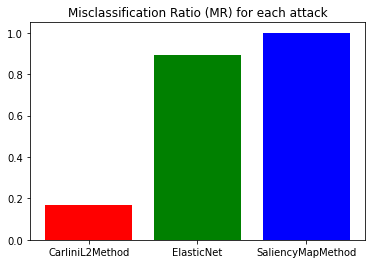

In [ ]:
# Make a plot
X = ['CarliniL2Method','ElasticNet', 'SaliencyMapMethod']
plt.bar(X, [carlinil_mr, elastic_net_mr, saliency_mr], color=['r', 'g', 'b'])
plt.title('Misclassification Ratio (MR) for each attack')
plt.show()
plt.close()

## Part 2

### You need to complete the following.

In [ ]:
# Imports
from numpy import linalg as LA

for class_label in range(0, 10):
    print('For images of true class = {}'.format(class_label))
    norms_average = {'carlinil':{'l0': 0, 'l2':0, 'l_inf':0},
                     'elastic_net':{'l0': 0, 'l2':0, 'l_inf':0},
                     'saliency':{'l0': 0, 'l2':0, 'l_inf':0}
                     }
    print(norms_average['carlinil']['l0'])
    for i in range(final_train_y.shape[0]):
        cur_true_label = final_train_y[i].tolist().index(1)
        if cur_true_label == class_label:
            for attack_method in ['carlinil', 'elastic_net', 'saliency']:
                if attack_method == 'carlinil': cur_adv_examples = carlinil_adv_examples
                elif attack_method == 'elastic_net': cur_adv_examples = elastic_net_adv_examples
                elif attack_method == 'saliency': cur_adv_examples = saliency_adv_examples
                x_diff = (final_train_x[i].squeeze() - cur_adv_examples[i].squeeze()).reshape(-1)
                norms_average[attack_method]['l0'] += LA.norm(x_diff,0)
                norms_average[attack_method]['l2'] += LA.norm(x_diff,2)
                norms_average[attack_method]['l_inf'] += LA.norm(x_diff,np.inf)
            
    print('Methods \t L0 \t L2 \t L_inf')
    for attack_method in ['carlinil', 'elastic_net', 'saliency']:
        l0_average = norms_average[attack_method]['l0']/10
        l2_average =  norms_average[attack_method]['l2']/10
        linf_average = norms_average[attack_method]['l_inf']/10
        print('{} \t {} \t {} \t {}'.format(attack_method, l0_average, l2_average, linf_average))
    print('\n')


For images of true class = 0
0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 258.6 	 0.09172788955163867 	 0.01984835701440584
elastic_net 	 265.2 	 1.0423769590445127 	 0.23129044197333054
saliency 	 207.5 	 4.089531542156119 	 0.9789051996147767


For images of true class = 1
0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 446.6 	 0.672769236956192 	 0.17081010435483965
elastic_net 	 126.8 	 1.7216030418702766 	 0.56066835913483
saliency 	 102.0 	 2.708025200856394 	 1.0


For images of true class = 2
0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 360.5 	 0.2745396957727049 	 0.10875636143934006
elastic_net 	 231.6 	 1.4902208772537944 	 0.5773920211860758
saliency 	 187.7 	 2.7635956176131433 	 0.9752858845411044


For images of true class = 3
0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 228.2 	 0.10015636704859887 	 0.028220982691505792
elastic_net 	 290.9 	 3.395038496232599 	 0.5866132993594151
saliency 	 174.2 	 3.4575026507173954 	 1.0


For images of true class = 4
0
Methods 	 L0 	 L2 	 L_inf
carlinil 	 142.

## Part 3

### You need to complete the following.

In [ ]:
# Imports
from google.colab import drive
drive.mount('/content/drive')

import sys
sys.path.insert(0,'drive/My Drive/HW4P')

import network.network as Network
import network.mnist_loader as mnist_loader
import pickle
# Reload the trained model from HW#3 Problem 4
import network.network as Network
import network.mnist_loader as mnist_loader
import pickle

# Load the pre-trained model.
with open('/content/drive/MyDrive/HW4P/network/trained_network.pkl', 'rb') as f:
    u = pickle._Unpickler(f)
    u.encoding = 'latin1'
    target_net = u.load()

Mounted at /content/drive


In [ ]:
def predict_using_target_net(x, verbose=False):
    x = x.squeeze().reshape(-1, 1)
    outputs = target_net.feedforward(x)
    predictions = np.argmax(outputs)
    if verbose:
        print('Network output: \n' + str(np.round(outputs, 2)) + '\n')
        print('Network prediction: ' + str(predictions) + '\n')
        print('Actual image: ')
    
        # Draw the image
        plt.imshow(x.reshape((28,28)), cmap='Greys')
    return predictions

In [ ]:
print(carlinil_adv_examples.shape)

(100, 1, 28, 28)


In [ ]:
# Evaluate whether adversarial examples generated with the substitute model will transfer to the target model
for attack_method in ['carlinil', 'elastic_net', 'saliency']:
    model_preds=[]
    if attack_method == 'carlinil': 
      for img in carlinil_adv_examples:
        model_preds.append(predict_using_target_net(img))
    elif attack_method == 'elastic_net': 
      for img in elastic_net_adv_examples:
        model_preds.append(predict_using_target_net(img))
    elif attack_method == 'saliency':
      for img in saliency_adv_examples:
        model_preds.append(predict_using_target_net(img))

    #predictions = predict_using_target_net(cur_adv_examples)
    predictions = model_preds
    predictions = np.asarray(predictions)
    mr = accuracy_score(predictions, np.argmax(target_y,axis=1))
    print('For {}, Misclassification Ratio = {}'.format(attack_method, mr))

For carlinil, Misclassification Ratio = 0.03
For elastic_net, Misclassification Ratio = 0.18
For saliency, Misclassification Ratio = 0.11


Therefore we can see that the adversarial samples are transferable. 

## Part 4

### You need to complete the following.

In [ ]:
# Imports
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC

In [ ]:
# Re-load the MNIST dataset
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalization
x_train = keras.utils.normalize(x_train, axis=1)
x_test = keras.utils.normalize(x_test, axis=1)

nb_trains = x_train.shape[0]
nb_tests = x_test.shape[0]

In [ ]:
x_train = x_train.reshape((x_train.shape[0],28*28))
x_test = x_test.reshape((x_test.shape[0],28*28))

In [ ]:
# ANN model
ann_parameters = {
'hidden_layer_sizes': [(100), (100,100)]
}

ann_clf = GridSearchCV(MLPClassifier(),ann_parameters,scoring='accuracy')
ann_clf.fit(x_train,y_train)
print(ann_clf.best_params_)

{'hidden_layer_sizes': (100, 100)}


In [ ]:
# SVM model
svm_parameters = {
    'kernel': ['rbf'],
    'C': [1, 10]
}

svm_clf = GridSearchCV(SVC(),svm_parameters)
svm_clf.fit(x_train,y_train)
print(svm_clf.best_params_)

{'C': 10, 'kernel': 'rbf'}


In [ ]:
# Logistic Regression model
lr_parameters = {
    'multi_class': ['auto'],
    'penalty' : ['l1', 'l2'],
    'C': [1, 10],
}

lr_clf = GridSearchCV(LogisticRegression(solver='liblinear'),lr_parameters)
lr_clf.fit(x_train,y_train)
print(lr_clf.best_params_)

{'C': 1, 'multi_class': 'auto', 'penalty': 'l1'}


In [ ]:
# kNN
knn_parameters = {
    'n_neighbors': [5],
    'weights': ['uniform', 'distance']
}
knn_clf = GridSearchCV(KNeighborsClassifier(),knn_parameters)
knn_clf.fit(x_train,y_train)
print(knn_clf.best_params_)

{'n_neighbors': 5, 'weights': 'distance'}


In [ ]:
# Naive Bayes
naive_bayes_parameters = {
    'var_smoothing': [1e-3, 1e-2, 1e-1]
}
naive_bayes_clf = GridSearchCV(estimator=GaussianNB(), param_grid=naive_bayes_parameters)
naive_bayes_clf.fit(x_train,y_train)
print(naive_bayes_clf.best_params_)

{'var_smoothing': 0.1}


In [ ]:
# Voting classifiers
voting_clf = VotingClassifier(estimators=[
                                ('naive_bayes', GaussianNB()),
                                ('ann', MLPClassifier()),
                                ('lr', LogisticRegression(solver='liblinear')),
                               ], voting='soft')

params = {
          'naive_bayes__var_smoothing': [1e-3, 1e-2, 1e-1],
          'lr__C': [1, 10],
          'ann__hidden_layer_sizes': [(100), (100,100)]}

voting_clf = GridSearchCV(voting_clf,params)
voting_clf.fit(x_train,y_train)


In [ ]:
print(voting_clf.best_params_)

{'ann__hidden_layer_sizes': (100, 100), 'lr__C': 10, 'naive_bayes__var_smoothing': 0.001}


In [ ]:
print(ann_clf.best_score_)
print(svm_clf.best_score_)
print(lr_clf.best_score_)
print(knn_clf.best_score_)
print(naive_bayes_clf.best_score_)
print(voting_clf.best_score_)

0.9715333333333334
0.9795666666666667
0.9148
0.9588333333333333
0.7967000000000001
0.9391


In [ ]:
classifier_names = ['ANN', 'SVM', 'Logistic Regression', 'kNN', 'Naive Bayes', 'Voting classifiers']
classifiers = [ann_clf, svm_clf, lr_clf, knn_clf, naive_bayes_clf, voting_clf]
print('Methods \t Test Acc \t Carlinil MR \t ElasticNet MR \t Saliency MR')
for i in range(len(classifiers)):
    preds=classifiers[i].predict(x_test)
    preds_carlini=classifiers[i].predict(carlinil_adv_examples.reshape(100,28*28))
    preds_elastic_net=classifiers[i].predict(elastic_net_adv_examples.reshape(100,28*28))
    preds_saliency=classifiers[i].predict(saliency_adv_examples.reshape(100,28*28))

    test_acc = accuracy_score(preds, y_test)
    carlinil_acc = accuracy_score(preds_carlini, np.argmax(target_y,axis=1))
    elasticnet_acc = accuracy_score(preds_elastic_net, np.argmax(target_y,axis=1))
    saliency_acc = accuracy_score(preds_saliency, np.argmax(target_y,axis=1))
    print('{} \t {} \t {} \t {} \t {}'.format(classifier_names[i], str(test_acc), str(carlinil_acc), str(elasticnet_acc), str(saliency_acc)))

Methods 	 Test Acc 	 Carlinil MR 	 ElasticNet MR 	 Saliency MR
ANN 	 0.9753 	 0.0 	 0.15 	 0.12
SVM 	 0.9817 	 0.0 	 0.15 	 0.09
Logistic Regression 	 0.9202 	 0.02 	 0.21 	 0.12
kNN 	 0.9622 	 0.0 	 0.07 	 0.05
Naive Bayes 	 0.8073 	 0.1 	 0.31 	 0.29
Voting classifiers 	 0.9371 	 0.02 	 0.16 	 0.14


We observe that the ElasticNet method has the highest transeferability followed by Saliency and then Carlinil in most cases. Now out of all the models, Naive Bayes Classifier has the highest transferability followed by Logistic Regression. SVM and ANN have comparable transferability and kNN has the least trasferability. The voting classifier being the combination of all models, it's transferability also seems to a combination of the other ones.  